In [1]:
#This notebook will walk through endotracheal tube position regression modeling with a convolutional neural network

#This will presume availability of MIMIC-CXR data for use but a later version will likely be adapted to function with RICORD

#Since MIMIC-CXR data is not contained in this repo, it will not be "plug and play" so to speak and will
#require significant external set up to run

In [2]:
#Imports, not all are critical for the code in this notebook, but better to have than have not

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import OPTICS

from difflib import SequenceMatcher

def sim1(a,b):
    return SequenceMatcher(None,a,b).ratio()

import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from torchvision.models import *
import yaml
import pandas as pd
import datetime
import numpy as np

from sklearn.metrics import roc_curve

#from torch.nn import *

from fastai.vision.models.wrn import wrn_22

from sklearn.metrics import roc_auc_score

import os

from fastai.callbacks import *

from fastai.callbacks.hooks import *

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import fastai.metrics as fm

import time

from torch.nn.modules.loss import L1Loss

import matplotlib

from torch.nn import functional as F
from torch.nn import _reduction as _Reduction

from fastai.vision.models import *

from sklearn.metrics import roc_curve

import random
import PIL
from scipy.ndimage import imread

from scipy import stats

In [3]:
#For doing DeLong method calculations, please see the excellent repo: https://github.com/yandexdataschool/roc_comparison

In [4]:
#We'll need MIMIC-CXR data to go any farther

#MIMIC is here: https://physionet.org/content/mimic-cxr/2.0.0/

#It has a github repo here: https://github.com/MIT-LCP/mimic-cxr

In [5]:
#With MIMIC-CXR, we can create a csv that will have all the report text and then file paths in the preceding column.

#The next code steps will presume that we have used Pandas to put all of our file paths into a CSV in one column with the text
#in the other column. CSV column names will be Files and Text

#With MIMIC data available, one way to generate this would be:

'''
path1='./MIMIC/files/'

stems1=os.listdir(path1)


pathls=[]

for si in stems1:
    folname=path1+si
    fols=os.listdir(folname)
    fols2=[folname+'/'+xi for xi in fols]
    
    for fs2 in fols2:
        fols2A=os.listdir(fs2)
        
        fols2B=[fs2+'/'+xi for xi in fols2A]
        
        pathls=pathls+fols2B


#All the files are now in pathls
dict1={'Files': pathls}
df1=pd.DataFrame(dict1)
#df1.to_csv('MIMICFileNames.csv')

textdatals=[]
ct=0
for oname in pathls:

    with open(oname, 'r') as file:
        textdata = file.read()
    textdatals.append(textdata)
    ct=ct+1
    if ct%40000==0:
        print(ct)
    
dict2={'Files': pathls,'Text':textdatals}
df2=pd.DataFrame(dict2)
df2.to_csv('mtext.csv')


'''

"\npath1='./MIMIC/files/'\n\nstems1=os.listdir(path1)\n\n\npathls=[]\n\nfor si in stems1:\n    folname=path1+si\n    fols=os.listdir(folname)\n    fols2=[folname+'/'+xi for xi in fols]\n    \n    for fs2 in fols2:\n        fols2A=os.listdir(fs2)\n        \n        fols2B=[fs2+'/'+xi for xi in fols2A]\n        \n        pathls=pathls+fols2B\n\n\n#All the files are now in pathls\ndict1={'Files': pathls}\ndf1=pd.DataFrame(dict1)\n#df1.to_csv('MIMICFileNames.csv')\n\ntextdatals=[]\nct=0\nfor oname in pathls:\n\n    with open(oname, 'r') as file:\n        textdata = file.read()\n    textdatals.append(textdata)\n    ct=ct+1\n    if ct%40000==0:\n        print(ct)\n    \ndict2={'Files': pathls,'Text':textdatals}\ndf2=pd.DataFrame(dict2)\ndf2.to_csv('mtext.csv')\n\n\n"

In [6]:
#If we call this CSV "mtext.csv" we can then start looking a content distributions quickly such as: 

df=pd.read_csv('mtext.csv')

def wordcheck(x,word):
    if word in x or word.lower() in x:
        y=1
    else:
        y=0
    return y

textdata=df['Text']
labs1=textdata.apply(wordcheck,args=['ET tube'])

fls=df['Files']

In [7]:
#Since we can anticipate using CLAHE as pre-processing we can also potentially make a separate folder from the MIMIC
#data with images that are already processed with CLAHE. These would be in the folder './pAHdump/' for the purposes of this
#walk through

#One way to do this would be:

# hct=0
# for fn in nametempls:
#     imA=imread(fn)
#     s1=fn.split('/')[-1]
#     imAE = exposure.equalize_adapthist(imA, clip_limit=0.03)
#     s2='./pAHdump/AH-'+s1
#     imsave(s2,imAE)
#     hct=hct+1
#     if hct%1000==0:
#         print(hct)

#In this example snippet, nametempls would be generated by the user
#as a list of image names after extracting image data from MIMIC-CXR

dumpls=os.listdir('./pAHdump/')

In [8]:
#Then we can do some more parsing to expand the CSV/Pandas dataframe

def fnparse(fname):
    f1=fname.split('/')
    f2=f1[-1].split('.')[0]
    return f2

def fnpatparse(fname):
    f1=fname.split('/')
    f2=f1[-2]
    return f2

df['Stem']=df['Files'].apply(fnparse)

df['Patient']=df['Files'].apply(fnpatparse)

In [9]:
#Okay, now we can make a function to parse the text for a keyword

def namegrabber2(keyword):
    labelset1=textdata.apply(wordcheck,args=[keyword])
    dkeyL=np.array(labelset1)
    dkeyL2=np.where(dkeyL==1)[0]
    dfgrab=df.iloc[dkeyL2,:]
    flskey=list(fls[dkeyL2])
    stemlskey=[]
    for fx in flskey:
        fs=fx.split('/')
        n1=fs[-1].split('.')[0]
        stemlskey.append(n1)
    plskey1=[]
    plskey2=[]
    for pf in dumpls:
        ps=pf.split('-')[1]
        if ps in stemlskey:
            plskey1.append(ps)
            plskey2.append(pf)
    return plskey2, dfgrab

In [10]:
#Now we can look for our target phrase for this application

pETcm, dfcm1=namegrabber2(' cm above the carina')

dfcm1a=dfcm1.reset_index()

In [11]:
#Now we can write a function to extract the number data we want from the text files

def cmextractv2(st2):
    st1="".join(st2.splitlines())
    targ1=' cm above the carina'
    targlen=len(targ1)
    pos1=st1.find(targ1)
    subtarg=st1[pos1-3:pos1]
    if ' ' in subtarg:
        posS=subtarg.find(' ')
        subtarg2=subtarg[posS+1:]
    else:
        subtarg2=subtarg
    if '-' in subtarg2:
    #    #Deal with range
        try:
            num1=float(subtarg2[0])
            num2=float(subtarg2[2])
            subtarg2=str((num1+num2)/2)
        except:
            #Turns out this is always 9-10 overflowing the strings but this is now a hard coded assumption
            #for the data based on MIMIC-CXR, caution when applying to other data
            subtarg2='9.5'
            #print(subtarg2)
    #outnum=subtarg2
    try:
        ftarg=float(subtarg2)
    except:
        print(subtarg2)
    return subtarg2
    

In [12]:
mstrs2=dfcm1a['Text'].apply(cmextractv2)

def makefloaty(vx):
    try:
        fv=float(vx)
    except:
        fv=-1
    return fv

dfcm1a['Extract1v2']=mstrs2
dfcm1a['Extract2v2']=dfcm1a['Extract1v2'].apply(makefloaty)

dfend2a=dfcm1a[dfcm1a.Extract2v2!=-1]

_.3
a


is
_.2
___
one
is
_.5
is
ely
_.9
a
a

_.5

ly5
is
_.9



In [13]:
#Remove exclusions - these were manually reviewed and the reports were found to not be suitable for use
#These exclusions are typically due to dictation errors

dfend2=dfend2a[~dfend2a.Stem.isin(['s50525300','s59537738','s53286099',
                                   's53859965','s54573322','s57795291','s52974561','s58191227','s51505331'])]

In [14]:
stemlsEF=list(dfend2['Stem'])
reglstmp=list(dfend2['Extract2v2'])
EFz=zip(stemlsEF,reglstmp)

dfstem=dfend2.set_index('Stem')

ETFls=[]
regls=[]
for pf in dumpls:
    ps=pf.split('-')[1]
    if ps in stemlsEF:
        ETFls.append(pf)
        regls.append(dfstem['Extract2v2'].loc[ps])

In [15]:
etregls1=list(dfend2['Extract2v2'])
cmult=np.max(etregls1)
print(cmult)
etregls1a=regls/np.max(etregls1)

#Okay we now have a normalized list of values which we can work with for CNN regression

13.0


In [16]:
fnamesreg=['./pAHdump/'+efx for efx in ETFls]

In [17]:
#We can also look at other keyword phrases of interest

pbcar, dfbcar=namegrabber2('below the carina')
print(len(pbcar))

pmb, dfmb=namegrabber2('mainstem bronchus')
print(len(pmb))

pmb2, dfmb2=namegrabber2('bronchus intubation')
print(len(pmb2))

pmb3, dfmb3=namegrabber2('cm from the carina')
print(len(pmb3))

pcm, dfcm2=namegrabber2(' cm ')
print(len(pcm))

135
500
41
1979
18780


In [18]:
#Alteration of placement
pbad1, dfbad=namegrabber2('be pulled back')
pbad2, dfbad2=namegrabber2('be advanced')
pbad3, dfbad3=namegrabber2('be withdrawn')

In [19]:
#If we want to check how performance might vary with DICOM parameters, then we can extract these from the MIMIC DICOMs
#and put them in a CSV to read in now. This was done in 10 parts based on how MIMIC is divided. What matters for this notebook
#is having a field for pixel spacing, PixSpA2 in this setting. Also, the second field dimension for image height, FieldDim2

fdicomstem='./dicomextractsv1/MIMICv1/'
fdname=fdicomstem+'p10ex1.csv'
fdicom=pd.read_csv(fdname)

for x in range(1,10):
    fdname=fdicomstem+'p1'+str(x)+'ex1.csv'
    fdtemp=pd.read_csv(fdname)
    fdicom=pd.concat([fdicom, fdtemp],axis=0,ignore_index=True)
    
fdcls=fdicom['Files']

fdcls[1].split('/')[4]
fdsn=[]
for fdt in fdcls:
    fdsn.append(fdt.split('/')[4])
    
fdicom['FileSplit']=fdsn

dfe=fdicom.loc[fdicom['FileSplit'] == fnamesreg[0].split('-')[1]]

ect=0
for fx1 in fnamesreg[1:]:
    fi1=fx1.split('-')[1]
    dfslot=fdicom.loc[fdicom['FileSplit']==fi1]
    dfe=dfe.append(dfslot)
    ect=ect+1
    
dfed=dfe.drop_duplicates()

dfed.reset_index(inplace=True)

etn1=list(etregls1a)
fregn1=fnamesreg

pixls=dfed['PixSpA2']

hls=dfed['FieldDim2']

pixquant=np.array(pixls*hls)

pg=np.where(pixquant!=0)[0]

In [20]:
altet=etn1*pixquant/np.max(pixquant*etn1)
etn1=np.array(etn1)
etn1a=etn1[pg]
alteta=altet[pg]
fregn1a=[fregn1[x] for x in pg]
#So now we've got a set up where we can correct for pixel spacing in different ways if we want to, but feel free not to and just
#use the label/file setup in the prior cells

In [21]:
#Can create a variant of MAE to train with instead of MSE if desired
def MAELossFlat(*args, axis:int=-1, floatify:bool=True, **kwargs):
    "Similar `nn.MSELoss`/L1Loss, but flattens input and target."
    return FlattenedLoss(nn.L1Loss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [22]:
#AI time, FastAI time to be more specific, we have so far just been setting up our image list and label list

#For more on FastAI, see: https://github.com/fastai/fastai and https://docs.fast.ai/

#Decide on our image transforms/augmentations, we'll be going with this
tfms2d=get_transforms(do_flip=False, max_rotate=30, max_zoom=1.15, max_lighting=.25)
#Many other ways to set up image augs are possible though, see https://docs.fast.ai/vision.transform.html

#Set up the data bunch in FastAI. We have our list of image names, our list of labels, our validation percent, batch size,
#image resolution/size, and image transform bundle
dataETreg500d=ImageDataBunch.from_lists(path='./modelET',fnames=fnamesreg,labels=etregls1a,
                                        valid_pct=.05, seed=1, bs=8, size=500, ds_tfms=tfms2d)


arch1=densenet121 #Can change this to sample many different architectures
learn=cnn_learner(dataETreg500d,arch1,pretrained=True,loss_func=MAELossFlat()) #Initialize a CNN without trying to compare to
#pixel spacing later

#If we want to potentially work with pixel spacing in analysis:
nd500psNoR=ImageDataBunch.from_lists(path='./modelET',fnames=fregn1a,labels=etn1a,
                                     valid_pct=.05, seed=1, bs=8, size=500, ds_tfms=tfms2d)

#Initialize another CNN
learnR=cnn_learner(nd500psNoR,arch1,pretrained=True,loss_func=MAELossFlat())

In [23]:
#We can train for a bit like this:
lr=0.005 #learning rate
numepochs=2
learnR.unfreeze()
learnR.fit_one_cycle(numepochs,lr,callbacks=[SaveModelCallback(learnR, every='improvement', monitor='valid_loss', name='trialtrain1')])

epoch,train_loss,valid_loss,time
0,0.194704,0.158974,12:35
1,0.106550,0.111163,12:14


Better model found at epoch 0 with valid_loss value: 0.15897388756275177.
Better model found at epoch 1 with valid_loss value: 0.11116261780261993.


In [24]:
#Here's how one model was trained:
#The 5-30 number is epochs, the 0.0005-0.001 number is learning rate, names are intermediate save states

'''
10 at 0.001 - noR_restartv1
10 more at 0.0005 - noR_restartv1a
5 to try fit vs fit_one_cycle at 0.0005 - noR_restaratv1b, not a significant improvement
10 at 0.0005 with unfrozen backbone - noR_restartv1auf - terminated after 3 epochs due to worsening performance at 500x500 pixel resolution
Trying to resize to lower res first with a bigger batch size - 32 and 256x256
noR_restartv1rs - 10 epochs, down to 0.075 loss
noR_restartv1rsuf - 10 epochs after unfreezing from prior model, down to 0.06
noR_restartv1rsuf2 - 10 more epochs, slightly below 0.06
noR_restartv1rsuf3 - 30 epochs, 24th epoch selected at 0.056 -> 0.73 cm MAE at 256x256
Then back to 500x500 with batch size 8 instead of 32 batch size at 256x256
noR_backto500v1 - 5 epochs frozen 0.06
noR_backto500v1a - 5 epochs unfrozen 0.056
noR_backto500v1b - 10 more epochs unfrozen 0.053 loss

Total epochs - 115

'''



'\n10 at 0.001 - noR_restartv1\n10 more at 0.0005 - noR_restartv1a\n5 to try fit vs fit_one_cycle at 0.0005 - noR_restaratv1b, not a significant improvement\n10 at 0.0005 with unfrozen backbone - noR_restartv1auf - terminated after 3 epochs due to worsening performance at 500x500 pixel resolution\nTrying to resize to lower res first with a bigger batch size - 32 and 256x256\nnoR_restartv1rs - 10 epochs, down to 0.075 loss\nnoR_restartv1rsuf - 10 epochs after unfreezing from prior model, down to 0.06\nnoR_restartv1rsuf2 - 10 more epochs, slightly below 0.06\nnoR_restartv1rsuf3 - 30 epochs, 24th epoch selected at 0.056 -> 0.73 cm MAE at 256x256\nThen back to 500x500 with batch size 8 instead of 32 batch size at 256x256\nnoR_backto500v1 - 5 epochs frozen 0.06\nnoR_backto500v1a - 5 epochs unfrozen 0.056\nnoR_backto500v1b - 10 more epochs unfrozen 0.053 loss\n\nTotal epochs - 115\n\n'

In [25]:
#So we can just load this model, the noR is for no rescaling based on DICOM pixel spacing parameters
learnR.load('noR_backto500v1b')

Learner(data=ImageDataBunch;

Train: LabelList (8555 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: FloatList
0.46153846,0.17692308,0.43076923,0.35384616,0.13846155
Path: modelET;

Valid: LabelList (450 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: FloatList
0.36153847,0.30769232,0.3,0.42307693,0.61538464
Path: modelET;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [26]:
#Get some functions ready for stats

def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def rCI(r, alpha, n):
    #confidence interval for r
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf((1 + alpha)/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

0.6881699
[[1.       0.843883]
 [0.843883 1.      ]]


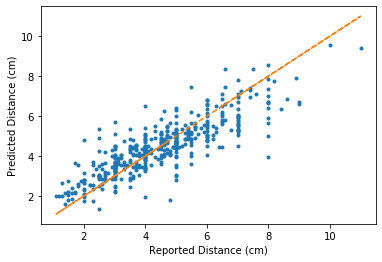

In [27]:
#Now look at the model results

pr,yr,lossr = learnR.get_preds(with_loss=True)

ynr=np.array(to_np(yr))*cmult

pnr1a=np.concatenate(to_np(pr),axis=0)*cmult 

ydiffr=pnr1a-ynr
plt.plot(ynr,pnr1a,'.')
plt.plot(ynr,ynr,'--')
plt.xlabel('Reported Distance (cm)')
plt.ylabel('Predicted Distance (cm)')
print(np.mean(np.abs(ydiffr)))
print(np.corrcoef(ynr,pnr1a))

Text(0, 0.5, 'Difference')

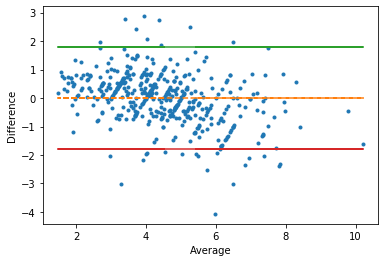

In [38]:
#Can also do Bland-Altman plots
avgrun=(pnr1a+ynr)*0.5
diffrun=ydiffr
totavg=np.mean(avgrun)
diffavg=np.mean(ydiffr)
plt.plot(avgrun,diffrun,'.')
plt.plot(avgrun,np.ones(len(avgrun))*diffavg,'--') #Plot the average line for the differences
lim1=diffavg+1.96*np.std(ydiffr)*np.ones(len(avgrun))
lim2=diffavg-1.96*np.std(ydiffr)*np.ones(len(avgrun))
plt.plot(avgrun,lim1,'-')
plt.plot(avgrun,lim2,'-')
plt.xlabel('Average')
plt.ylabel('Difference')